Connected to atos (Python 3.11.7)

<ipython-input-1-d16d376675c8>:60: RuntimeWarning: invalid value encountered in log10
  eff_arr = np.log10(np.divide(1-met_arr, eng_arr))


TypeError: Colorbar.__init__() got an unexpected keyword argument 'label_kwargs'

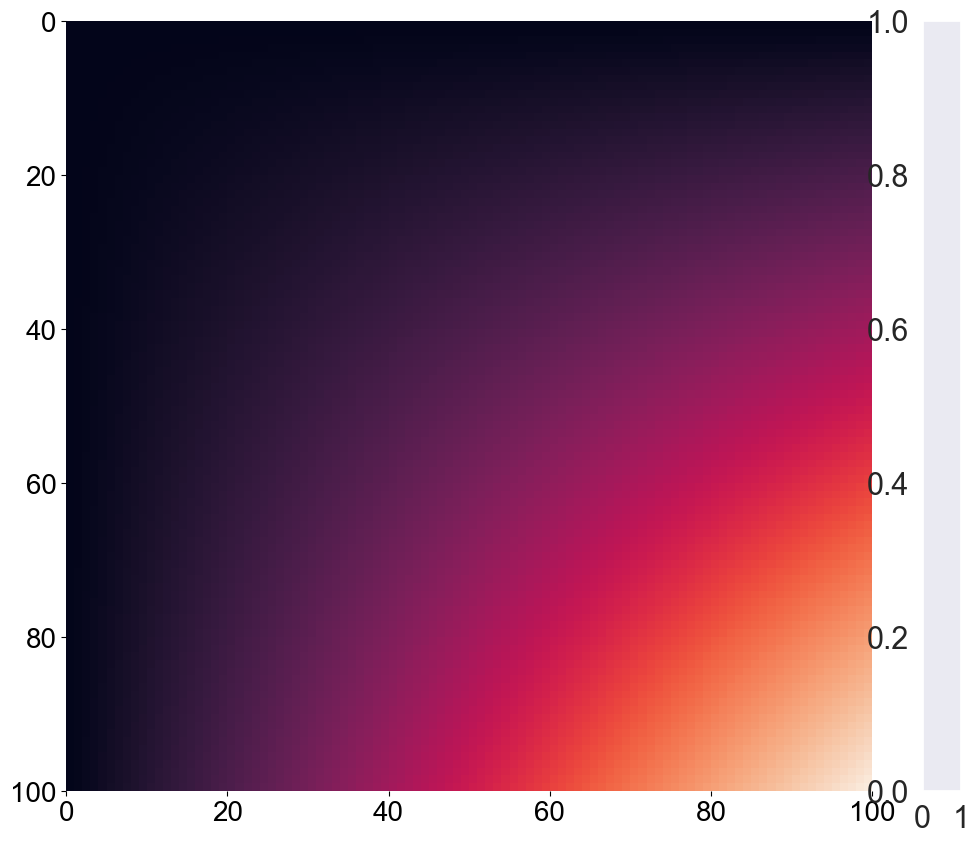

In [ ]:
from multiprocessing import Pool
import numpy as np
import itertools
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib.ticker as ticker


delta = -7.712
#alp0 = 1.0589003542176467
#omega = 0.6709446472822442 
#E0 = 4.1054927116664945
kappa = 0.02
#E000 = 0.0643109474333867 #change for different noise
#E001 = 0.5706839345786814 #change for different noise
eps = 10**(-5)

gam1 = 1.55 #nu_0
omg1 = 0.71 #delta
E0INF = 4.1 #beta
E00 = 2 #alpha

plt.rcParams.update({'font.size': 20})

#EXPRESSION FOR GENERAL SOLN OF METRIC AS A FUNCTION OF T AND NG
#def final_energy(NN, tt):
#    Einf1 = (E000 * (NN**(E001))) *np.exp(-(alp0 * (NN**(-omega))) * tt)+ ((1 - eps)**((NN/2) - 1)) * (E0*np.exp(-kappa*NN) + delta) - delta
#    prod = NN*tt
#    return([Einf1, prod])

def final_energy(NN, tt):
    Einf1 = ((1 - eps)**(NN)) * (E0INF*np.exp(-kappa*NN) + delta + E00 *np.exp(-gam1*tt*(NN**(-omg1)))) - delta
    prod = NN*tt
    return([Einf1, prod])

t = np.linspace(1, 1001, 100, dtype = int)
N = np.linspace(1, 1001, 100, dtype = int)

countour_vals = [0.05, 0.1, 0.25]

#defining main
def main():
    spann =  list(itertools.product(N, t))
    #print(spann)
    with Pool() as p:
        res_pool = p.starmap(final_energy, spann) 
    metric = [] # error
    energy = [] # energy
    for it in res_pool:
        metric.append(it[0])
        energy.append(it[1])
    return(metric, energy)

if __name__=="__main__": 
    a, b = main()

    met_arr = np.reshape(a, (int(len(N)), int(len(t))))
    eng_arr = np.reshape(b, (int(len(N)), int(len(t))))
    eff_arr = np.log10(np.divide(1-met_arr, eng_arr))
    
    # First plot (Resources plot)
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['axes.titlepad'] = 20
    fig1, ax1 = plt.subplots(figsize=(13, 10))
    sns.set(font_scale=2)

    # Create heatmap for resources
    axz = sns.heatmap(eng_arr, cmap="rocket", 
                    cbar_kws={'label': 'Total algorithmic resources', 
                             'label_kwargs': {'fontsize': 20}})

    # Plot contours and minimum resource points
    for contour_val in countour_vals:
        contour_points = np.where(np.isclose(met_arr, contour_val, atol=1e-2))
        resources = N[contour_points[0]] * t[contour_points[1]]
        min_resource_idx = np.argmin(resources)
        
        # Plot contour line
        c = ax1.contour(np.arange(.5, met_arr.shape[1]), np.arange(.5, met_arr.shape[0]), 
                        met_arr, [contour_val,], colors='yellow', alpha=0.9, linestyles='dotted')
        ax1.clabel(c, [contour_val, ], inline=1, fontsize=20)
        
        # Mark minimum resource point
        ax1.plot(contour_points[1][min_resource_idx], contour_points[0][min_resource_idx], 
                'w*', markersize=15)

    # Resource contours
    fmt = ticker.LogFormatterSciNotation()
    fmt.create_dummy_axis()
    c4 = ax1.contour(np.arange(.5, eng_arr.shape[1]), np.arange(.5, eng_arr.shape[0]), 
                    eng_arr, [10000, 25000, 50000, 100000, 200000], 
                    colors='cyan', alpha=0.5, linestyles='dashed')
    ax1.clabel(c4, [10000, 25000, 50000, 100000, 200000], inline=1, fmt=fmt, fontsize=20)

    # Second plot (Efficiency plot)
    fig2, ax2 = plt.subplots(figsize=(13, 10))


    # Create heatmap for efficiency
    axeff = sns.heatmap(eff_arr, cmap=sns.color_palette("Greens",12), 
                        cbar_kws={'label': r'$Log_{10}(\eta)$',
                                 'label_kwargs': {'fontsize': 20}}, 
                        vmin=-7, vmax=-4)

    # Plot contours and maximum efficiency points
    for contour_val in countour_vals:
        contour_points = np.where(np.isclose(met_arr, contour_val, atol=1e-2))
        efficiencies = eff_arr[contour_points]
        max_eff_idx = np.argmax(efficiencies)
        
        # Plot contour line
        c = ax2.contour(np.arange(.5, met_arr.shape[1]), np.arange(.5, met_arr.shape[0]), 
                        met_arr, [contour_val,], colors='blue')
        ax2.clabel(c, [contour_val, ], inline=1, fontsize=20)
        
        # Mark maximum efficiency point
        ax2.plot(contour_points[1][max_eff_idx], contour_points[0][max_eff_idx], 
                'w*', markersize=15)

    # Common settings for both plots
    for ax in [ax1, ax2]:
        ax.set_xticks(np.linspace(1, 100, 10))
        ax.set_xticklabels(np.linspace(1, 1001, 10, dtype=int), fontsize=20)
        ax.set_yticks(np.linspace(1, 100, 10))
        ax.set_yticklabels(np.linspace(1, 1001, 10, dtype=int), fontsize=20)
        ax.invert_yaxis()
        ax.set_xlabel(r'$t$', fontsize=20)
        ax.set_ylabel(r'$N_g$', fontsize=20)

    plt.show()